### Import required packages

In [126]:
import os
import cv2
import spectrum
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import getenv
from glob import glob
from tqdm import tqdm, tqdm_notebook
from librosa.feature import chroma_stft
from collections import Counter

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sentsation.connect import get_s3_client, get_s3_resource
from sentsation.audio.feature_extraction import AudioFeature

from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.regularizers import l2


### Convert files to .wav  
either get local files or from AWS S3 bucket

In [ ]:
# S3_KEY = getenv('AWS_KEY')
# S3_SECRET = getenv('AWS_SECRET')
# AWS_REGION = getenv('AWS_REGION', 'eu-west-2')
# bucket_name = getenv('S3_BUCKET')
# s3r = get_s3_resource(session_token)
# bucket = s3r.Bucket(bucket_name)
# s3 = get_s3_client(session_token)

## Feature Selection
Explore various features that can be extracted from an audio file and select the most representative ones for model training  

Ref: https://librosa.github.io/librosa/tutorial.html

In [278]:
filename = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt1.wav'

### Basic: sample rate, duration
Loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. The variable sr contains the sampling rate of y, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to librosa.load().  
- Load the audio as a waveform *y* [audio signal]  
- store the sampling rate as *sample_rate* [audio sampling rate of y]  

In [279]:
y, sample_rate = librosa.load(filename)

In [280]:
y

array([ 0.00339063,  0.00709252,  0.00853075, ..., -0.00181594,
       -0.00094435,  0.        ], dtype=float32)

In [281]:
print(sample_rate, len(y))

22050 29636


In [282]:
librosa.get_duration(y, sample_rate)

1.3440362811791384

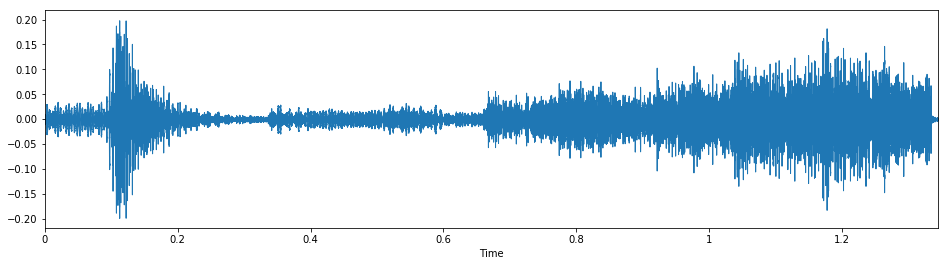

In [283]:
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sample_rate)

Run the default beat tracker. The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. Since v0.3, librosa uses centered frames, so that the kth frame is centered around sample k * hop_length.

The next operation converts the frame numbers beat_frames into timings

In [284]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sample_rate)

In [285]:
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 143.55 beats per minute


Convert the frame indices of beat events into timestamps

In [286]:
beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)
beat_times

array([0.13931973, 0.55727891])

### MFCC  
Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition.  
Compute MFCC features from the raw signal  
- *y* [audio time series]
- *n_mfcc* [number of MFCCs to return]

In [295]:
mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, hop_length=256, n_mfcc=5)
print('Computed {} MFCCs over {} frames.'.format(mfccs.shape[0], mfccs.shape[1]))

Computed 5 MFCCs over 116 frames.


In [296]:
mfcc_avg = np.mean(mfccs.T,axis=0) 
mfcc_avg

array([-273.94262637,  120.35753494,  -20.39380648,   18.31063071,
         -6.82328171])

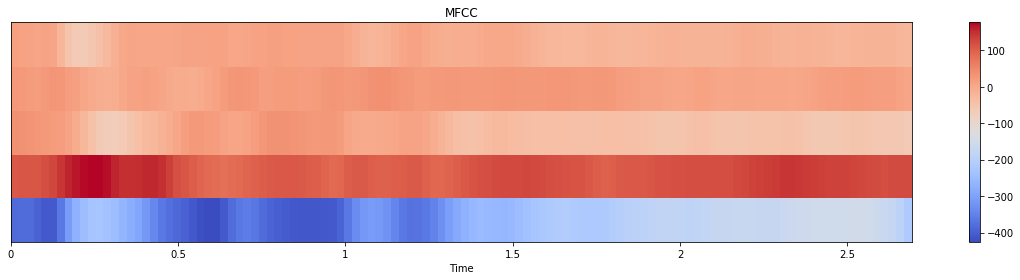

In [298]:
plt.figure(figsize=(16, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [305]:
# S = librosa.feature.melspectrogram(y=y, sr=sample_rate)
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)
len(S)

128

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128, fmax=8000)

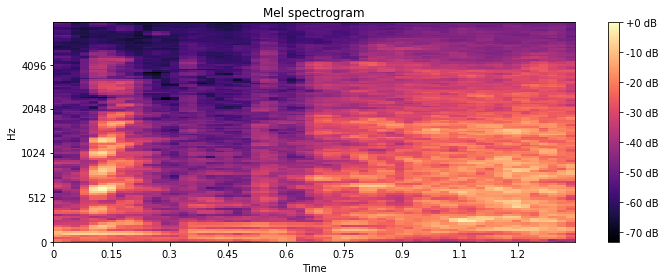

In [310]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

__Feature Scaling__  
Scale the MFCCs such that each coefficient dimension has zero mean and unit variance

In [ ]:
mfccs = scale(mfccs, axis=1)
print('Mean: \n', mfccs.mean(axis=1), '\n\nVariance: \n', mfccs.var(axis=1))

In [ ]:
plt.figure(figsize=(16, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Power / Energy
Apply Short-time Fourier transform (stft)  
- np.abs(D[f, t]) is the magnitude of frequency bin f at frame t  
- np.angle(D[f, t]) is the phase of frequency bin f at frame t

In [ ]:
S = np.abs(librosa.stft(y))
# Compute a chromagram from a waveform or power spectrogram
chroma = chroma_stft(S=S, sr=sample_rate)
print('Chroma is a array with shape: ', chroma.shape)
chroma

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### Energy  
Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.  
- *S* [spectrogram]  

Example: https://musicinformationretrieval.com/energy.html

In [ ]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)[0]

In [ ]:
librosa.feature.rms(y=y)[0]

Compute the short-time energy using a list comprehension:

In [ ]:
hop_length = 256
frame_length = 512
ST_energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])

In [ ]:
print(len(librosa.feature.rms(S=S)[0]), len(librosa.feature.rms(y=y)[0]), len(ST_energy))

Compute the RMSE

In [ ]:
ST_rmse = librosa.feature.rmse(y, frame_length=frame_length, hop_length=hop_length, center=True)
len(ST_rmse[0])

In [ ]:
frames = range(len(ST_energy))
time = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

In [ ]:
plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sample_rate, alpha=0.4, )
plt.plot(time, ST_energy/ST_energy.max(), 'r--')             # normalized for visualization
plt.plot(time, (ST_rmse/ST_rmse.max())[0], color='g')              # normalized for visualization
plt.legend(('Energy', 'RMSE'))

### Pitch  
Pitch is one of the characteristics of a speech signal and is measured as the frequency of the signal  
- "pitch_tuning": Given a collection of pitches, estimate its tuning offset (in fractions of a bin) relative to A440=440.0Hz.  
- "piptrack": Pitch tracking on thresholded parabolically-interpolated STFT.  
    - *threshold* - A bin in spectrum X is considered a pitch when it is greater than threshold*X.max()

In [ ]:
pitches, magnitudes = librosa.piptrack(y, sample_rate, threshold=0)
# Select out pitches with high energy
# pitches = pitches[magnitudes > np.median(magnitudes)]
librosa.pitch_tuning(pitches)

### [Comparison] Characteristics of different sentiment / emotion

In [ ]:
af_sadness = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt0.wav'
af_surprise = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt1.wav'
af_neutral = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt0.wav'
af_joy = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt1.wav'
af_anger = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt11.wav'

In [ ]:
y_sadness, sr_sadness = librosa.load(af_sadness)
y_surprise, sr_surprise = librosa.load(af_surprise)
y_neutral, sr_neutral= librosa.load(af_neutral)
y_joy, sr_joy = librosa.load(af_joy)
y_anger, sr_anger = librosa.load(af_anger)

y_list = [y_sadness, y_surprise, y_neutral, y_joy, y_anger]
sr_list = [sr_sadness, sr_surprise, sr_neutral, sr_joy, sr_anger]

#### MFCC

In [ ]:
def plot_mfcc(y, sr, hop_length=None, n_mfcc=None, use_scale=False, label=None):
    hop_length = hop_length or 256
    n_mfcc = n_mfcc or 13
    mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, hop_length=hop_length, n_mfcc=n_mfcc)
    if scale:
        mfccs = scale(mfccs, axis=1)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC for {}'.format(label))
    plt.tight_layout()

In [ ]:
for y, sr, label in zip(y_list, sr_list, ['sadness','surprise','neutral','joy','anger']):
    plot_mfcc(y, sr, use_scale=True, label=label)

#### Short-term Energy

In [ ]:
def plot_energy(y, sr, hop_length=None, frame_length=None, label=None):
    hop_length = hop_length or 256
    frame_length = frame_length or 512
    
    energy = np.array([sum(abs(y[i:i+frame_length]**2)) for i in range(0, len(y), hop_length)])
    rmse = librosa.feature.rmse(y, frame_length=frame_length, hop_length=hop_length, center=True)
    frames = range(len(energy))
    time = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    
    plt.figure(figsize=(6, 3))
    librosa.display.waveplot(y, sr=sr, alpha=0.4, )
    plt.plot(time, energy/energy.max(), 'r--')
    plt.plot(time, (rmse/rmse.max())[0], color='g')
    plt.title('Energy for {}'.format(label))
    plt.legend(('Energy', 'RMSE'))

In [ ]:
for y, sr, label in zip(y_list, sr_list, ['sadness','surprise','neutral','joy','anger']):
    plot_energy(y, sr, label=label)

#### Pitch

## Feature Extraction  
Kick off the feature extraction process for a list of audio files with selected features from previous section  
Firstly, save an image of mfcc / power spectrogram for each audio file  
(think about mfcc as reducing dimension of the power spectrogram, like applying TruncatedSVD) 

In [3]:
path_to_audiofiles = '/Users/cheuky/Downloads/MELD.RAW/audio'
afs_dev = glob(os.path.join(path_to_audiofiles,'dev','*.wav'))
afs_train = glob(os.path.join(path_to_audiofiles,'train','*.wav'))
afs_test = glob(os.path.join(path_to_audiofiles,'test','*.wav'))
print('Loaded',len(afs_dev),'audiofiles from dev; \nLoaded',len(afs_train),'audiofiles from train;',
    '\nLoaded',len(afs_test),'audiofiles from test')

Loaded 1112 audiofiles from dev; 
Loaded 9988 audiofiles from train; 
Loaded 2747 audiofiles from test


In [4]:
filenames = [af.split('/')[-1] for af in afs_dev]
filenames[:5]

['dia1_utt15.wav',
 'dia37_utt6.wav',
 'dia36_utt6.wav',
 'dia58_utt8.wav',
 'dia74_utt5.wav']

In [ ]:
# '.'.join(filenames[0].split('.')[:-1].append('jpg'))
filenames[0].split('.')[:-1] + ['jpg']

#### MFCC

In [ ]:
# def save_mfcc(audiofilelist, save_dir, hop_length=None, n_mfcc=None, use_scale=False):
#     hop_length = hop_length or 256
#     n_mfcc = n_mfcc or 13
#     for af in audiofilelist:
#         y, sr = librosa.load(af)
#         filename = str(af.split('/')[-1])
#         imagename = '.'.join(filename.split('.')[:-1] + ['jpg'])
#         mfccs = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
#         if scale:
#             mfccs = scale(mfccs, axis=1)
#         plt.figure(figsize=(25.6, 25.6), dpi=10)
#         librosa.display.specshow(mfccs)
#         plt.tight_layout()
#         plt.savefig('/'.join([save_dir, imagename]))

In [84]:
afs_trial = glob(os.path.join(path_to_audiofiles,'trial','*.wav'))
afext = AudioFeature()

In [ ]:
afext.save_mfcc_img(afs_dev, '/Users/cheuky/Downloads/MELD.RAW/features/mfcc/dev')
# save_mfcc(afs_trial, '/Users/cheuky/Downloads/MELD.RAW/features/mfcc/dev')

In [87]:
def extract_mfcc(audiofilelist, hop_length=None, n_mfcc=None, use_scale=False):
    hop_length = hop_length or 256
    n_mfcc = n_mfcc or 13
    mfccs_list = []
    for af in tqdm_notebook(audiofilelist):
        y, sr = librosa.load(af)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
        if scale:
            mfccs = scale(mfccs, axis=1)
        mfccs_list.append(mfccs)
    return mfccs_list

In [90]:
mfccs = extract_mfcc(afs_dev[:600])

## Import Metadata  
Obtain the metadata

In [2]:
path_to_metadata = '/Users/cheuky/Downloads/MELD.RAW'
meta_dev = pd.read_csv(os.path.join(path_to_metadata, 'dev_sent_emo.csv'))
meta_train = pd.read_csv(os.path.join(path_to_metadata, 'train_sent_emo.csv'))
meta_test = pd.read_csv(os.path.join(path_to_metadata, 'test_sent_emo.csv'))
print("Loaded {} datapoints from dev; \nLoaded {} datapoints from train; \nLoaded {} datapoints from test.".format(meta_dev.shape[0],
                                                                             meta_train.shape[0],
                                                                             meta_test.shape[0]))
meta_dev['Source'] = 'dev'
meta_train['Source'] = 'train'
meta_test['Source'] = 'test'

Loaded 1109 datapoints from dev; 
Loaded 9989 datapoints from train; 
Loaded 2610 datapoints from test.


Obtain a list of audio files

In [5]:
print('Loaded',len(afs_dev),'audiofiles from dev; \nLoaded',len(afs_train),'audiofiles from train;',
    '\nLoaded',len(afs_test),'audiofiles from test')

Loaded 1112 audiofiles from dev; 
Loaded 9988 audiofiles from train; 
Loaded 2747 audiofiles from test


In [6]:
meta_master = pd.concat([meta_dev, meta_train, meta_test])
meta_master['Filename'] = meta_master.apply(lambda row: "".join(['dia', str(row['Dialogue_ID']), '_',
                                                                'utt', str(row['Utterance_ID']), '.wav']) , axis=1)

In [7]:
print('Dataframe with shape: ', meta_master.shape)
meta_master['Filepath']=meta_master.apply(lambda r: '/'.join([path_to_audiofiles, r['Source'], r['Filename']]), axis=1)

Dataframe with shape:  (13708, 13)


### Join target labels with audio files

In [8]:
afs_df_dev = pd.DataFrame(afs_dev, columns=['Filepath'])
afs_df_train = pd.DataFrame(afs_train, columns=['Filepath'])
afs_df_test = pd.DataFrame(afs_test, columns=['Filepath'])
# afs_df_master = afs_df_dev.append([afs_df_train, afs_df_test])
afs_df_master = pd.concat([afs_df_dev, afs_df_train, afs_df_test], ignore_index=True)

In [9]:
print('There are {} metadata points and {} audio files. A difference of {}.'.format(
    meta_master.shape[0], afs_df_master.shape[0], abs(meta_master.shape[0]-afs_df_master.shape[0])))

There are 13708 metadata points and 13847 audio files. A difference of 139.


In [10]:
data_master = pd.merge(meta_master, afs_df_master, how='inner', on='Filepath')

In [11]:
print('Dataframe with shape: ', data_master.shape)
data_master.head(3)

Dataframe with shape:  (13706, 14)


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Source,Filename,Filepath
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dev,dia0_utt0.wav,/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia...
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dev,dia0_utt1.wav,/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia...
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dev,dia1_utt0.wav,/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia...


### Join features with labels

In [15]:
path_to_mfcc = '/Users/cheuky/Downloads/MELD.RAW/features/mfcc'
mfcc_df = data_master[['Emotion','Sentiment','Source','Filename']]
mfcc_df.head()

,Emotion,Sentiment,Source,Filename
0,sadness,negative,dev,dia0_utt0.wav
1,surprise,negative,dev,dia0_utt1.wav
2,neutral,neutral,dev,dia1_utt0.wav
3,joy,positive,dev,dia1_utt1.wav
4,sadness,negative,dev,dia1_utt2.wav


In [16]:
mfcc_df['MFCCpath'] = mfcc_df.apply(lambda r: '/'.join([path_to_mfcc, r.Source,
                                              r.Filename.replace('.wav','.jpg')]), axis=1)

/Users/cheuky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
mfcc_df.head(3)
list(mfcc_df.MFCCpath[:3])

['/Users/cheuky/Downloads/MELD.RAW/features/mfcc/dev/dia0_utt0.jpg',
 '/Users/cheuky/Downloads/MELD.RAW/features/mfcc/dev/dia0_utt1.jpg',
 '/Users/cheuky/Downloads/MELD.RAW/features/mfcc/dev/dia1_utt0.jpg']

In [136]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(256, 256))  # default input size for ResNet50 is 224x224
    x = image.img_to_array(img)  # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_tensors)

In [137]:
features = list(mfcc_df[mfcc_df.Source=='dev'].MFCCpath)
targets, uniques = pd.factorize(mfcc_df[mfcc_df.Source=='dev'].Sentiment)
y = to_categorical(targets, 3)

In [138]:
emo_targets, emo_uniques = pd.factorize(mfcc_df[mfcc_df.Source=='dev'].Emotion)
emo_y = to_categorical(emo_targets, 7)

In [139]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  

X = paths_to_tensor(features).astype('float32')/255

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
emo_X_train, emo_X_test, emo_y_train, emo_y_test = train_test_split(X, emo_y, test_size=0.33, random_state=42)

In [21]:
len(X_train)

742

In [238]:
X_train[]

array([[[0.96862745, 1.        , 0.9764706 ],
        [0.972549  , 1.        , 1.        ],
        [0.96862745, 1.        , 1.        ],
        ...,
        [1.        , 0.99607843, 0.99215686],
        [1.        , 0.99607843, 0.9843137 ],
        [1.        , 0.99215686, 0.9764706 ]],

       [[1.        , 1.        , 0.98039216],
        [1.        , 1.        , 0.99215686],
        [0.99215686, 0.9882353 , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99215686],
        [1.        , 1.        , 0.9843137 ]],

       [[1.        , 0.98039216, 0.95686275],
        [1.        , 0.9843137 , 0.9843137 ],
        [1.        , 0.9843137 , 1.        ],
        ...,
        [0.96862745, 0.9882353 , 1.        ],
        [0.9882353 , 1.        , 1.        ],
        [0.9843137 , 1.        , 0.99607843]],

       ...,

       [[1.        , 0.9764706 , 1.        ],
        [1.        , 0.9882353 , 1.        ],
        [1.        , 0

In [70]:
# features = numpy.vstack((mfcc_brahms_scaled, mfcc_busta_scaled))


In [49]:
X_train_mini = np.array([X_train[0], X_train[1], X_train[8], X_train[5], X_train[18]])
y_train_mini = np.array([y_train[0], y_train[1], y_train[8], y_train[5], y_train[18]])

In [106]:
y_train_mini

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [221]:
img_height, img_width=256, 256
batch_size=1
nb_epochs=1

datagen = image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, validation_split=0.2) # set validation split)

train_generator = datagen.flow_from_dataframe(dataframe=mfcc_df[mfcc_df['Source']=='dev'].head(100),
                                            directory=None, 
                                            x_col="MFCCpath", 
                                            y_col="Sentiment",
                                            color_mode='rgb',
                                            class_mode="categorical",
                                            target_size=(img_height, img_width), 
                                            batch_size=batch_size,
                                            subset='training')

valid_generator = datagen.flow_from_dataframe(dataframe=mfcc_df[mfcc_df['Source']=='dev'].head(100),
                                            directory=None, 
                                            x_col="MFCCpath", 
                                            y_col="Sentiment",
                                            color_mode='rgb',
                                            class_mode="categorical",
                                            target_size=(img_height, img_width), 
                                            batch_size=batch_size,
                                            subset='validation')

test_generator = datagen.flow_from_dataframe(dataframe=mfcc_df[mfcc_df['Source']=='test'].head(250),
                                            directory=None, 
                                            x_col="MFCCpath", 
                                            y_col="Sentiment",
                                            color_mode='rgb',
                                            class_mode="categorical",
                                            batch_size=batch_size, # make 1 prediction per datapoint
                                            target_size=(img_height, img_width))

Found 80 images belonging to 6 classes.
Found 20 images belonging to 6 classes.
Found 250 images belonging to 7 classes.


In [229]:
num_classes = 6

model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(3, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(3, (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(3, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 254, 254, 3)       84        
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 252, 252, 3)       84        
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 126, 126, 3)       0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 126, 126, 3)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 124, 124, 3)       84        
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 122, 122, 3)       84        
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 61, 61, 3)         0         
__________

In [230]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epochs)

Epoch 1/1
80/80 [==============================] - 6s 73ms/step - loss: 1.6455 - acc: 0.3500 - val_loss: 1.6160 - val_acc: 0.5500


In [231]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator, steps=nb_samples)

In [232]:
Counter([np.argmax(np.expand_dims(p, axis=0)) for p in predict])

Counter({3: 250})

### Distribution of labels

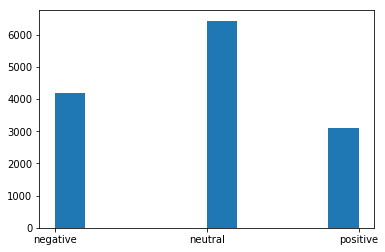

In [25]:
plt.hist(list(mfcc_df.Sentiment.values))
plt.show()

In [71]:
uniques

Index(['negative', 'neutral', 'positive'], dtype='object')

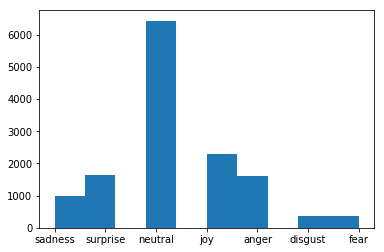

In [73]:
plt.hist(list(mfcc_df.Emotion.values))
plt.show()

In [74]:
emo_uniques

Index(['sadness', 'surprise', 'neutral', 'joy', 'anger', 'disgust', 'fear'], dtype='object')

## Building Models

### Dense

In [183]:
num_classes = 3
num_cols = 4

dense = Sequential()
dense.add (Flatten(input_shape=(224,224,3)))
dense.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
dense.add(Dense(64, activation='relu'))
dense.add(Dense(128, activation='relu'))
dense.add(Dense(num_classes, activation='softmax'))
dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 150528)            0         
_________________________________________________________________
dense_102 (Dense)            (None, 32)                4816928   
_________________________________________________________________
dense_103 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_104 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_105 (Dense)            (None, 3)                 387       
Total params: 4,827,747
Trainable params: 4,827,747
Non-trainable params: 0
_________________________________________________________________


In [185]:
dense.fit(X_train, y_train, epochs=1, verbose=1)

Epoch 1/1
742/742 [==============================] - 3s 3ms/step - loss: 10.1446 - acc: 0.3544


In [186]:
dense.predict_classes(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### CNN  
With the MFCC graphs, the audio-classification problem is now transformed into an image classification problem. Just like detecting presence of a particular entity (‘Dog’,’Cat’,’Car’ etc) in images.  
Consider using a CNN to classify the spectrogram images, because CNN works better in detecting local feature patterns (edges etc) in different parts of the image and are also good at capturing hierarchical features which become subsequently complex with every layer as illustrated in the image.  

In [118]:
img_width, img_height, channel = 32,32,3 # 224, 224, 3
num_classes = 3

cnn = Sequential()
cnn.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(img_width, img_height, channel)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(GlobalAveragePooling2D())
# cnn.add(Flatten())
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(num_classes, activation='sigmoid'))

cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 4, 4, 128)         32896     
__________

In [101]:
class_weight = {0: 1.5, 1: 1., 2: 1.8}

In [102]:
cnn.fit(X_train, y_train, epochs=1, class_weight=class_weight, verbose=1)

Epoch 1/1
742/742 [==============================] - 18s 24ms/step - loss: 2.4214 - acc: 0.3491


In [104]:
cnn.predict(X_test)

array([[0.6196404 , 0.57486117, 0.38166022],
       [0.6151857 , 0.57155204, 0.38660848],
       [0.6198319 , 0.5749575 , 0.38147035],
       ...,
       [0.6186607 , 0.57413435, 0.38275138],
       [0.6195521 , 0.5746976 , 0.38172722],
       [0.62001365, 0.5751121 , 0.38123465]], dtype=float32)

In [105]:
Counter([np.argmax(cnn.predict(np.expand_dims(tensor, axis=0))) for tensor in emo_X_test])

Counter({0: 366})

In [33]:
y_test[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

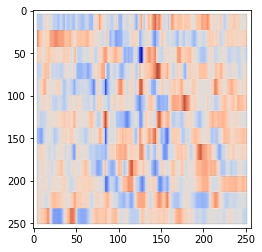

In [69]:
import cv2
img = cv2.imread(mfcc_df.MFCCpath[0])
plt.imshow(img)

#### Debugging CNN

In [113]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [119]:
datagen = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=1)

Epoch 1/1


ValueError: Error when checking target: expected dense_21 to have shape (3,) but got array with shape (1,)

In [ ]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('CNN accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper_left')
plt.show()

#### Data Augmentation

### Transfer learning + CNN (ResNet50)

In [72]:
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 13s 0us/step


In [73]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [74]:
[ResNet50_predict_labels(image) for image in X_train]

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# feature = mfccs
# label = row.Class
# X = np.array(temp.feature.tolist())
# y = np.array(temp.label.tolist())

# lb = LabelEncoder()

# y = np_utils.to_categorical(lb.fit_transform(y))

## Model Fusion

In [ ]:
fusion = Sequential()
fusion.add(Merge([model_text, model_speech], mode='concat'))

fusion.add(Activation('relu'))
fusion.add(Dense(256))
fusion.add(Activation('relu'))

fusion.add(Dense(4))
fusion.add(Activation('softmax'))